In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.preprocessing import StandardNormalizer, LabelEncoder, DataSplitter, DataPreprocessor
from src.models import XGBoostModel
from src.evaluation import CrossValidator, HyperparameterTuner, MetricsCalculator
from src.visualization import (
    ConfusionMatrixPlotter, ROCCurvePlotter,
    ParameterInfluencePlotter, PredictionScatterPlotter
)
import os

plt.rcParams['figure.dpi'] = 110
plt.style.use('seaborn-v0_8-darkgrid')

output_dir = 'heart_xgb_output'
os.makedirs(output_dir, exist_ok=True)

polish_labels = {
    'age': 'Wiek',
    'sex': 'Płeć',
    'cp': 'Typ bólu w klatce',
    'trestbps': 'Ciśnienie spoczynkowe',
    'chol': 'Cholesterol',
    'fbs': 'Cukier na czczo >120 mg/dl',
    'restecg': 'EKG spoczynkowe',
    'thalach': 'Maksymalne tętno',
    'exang': 'Ból wysiłkowy',
    'oldpeak': 'Obniżenie ST',
    'slope': 'Nachylenie ST',
    'ca': 'Naczynia barwione',
    'thal': 'Niedokrwistość tarczowatokrwinkowa',
    'condition': 'Choroba serca'
}

def pl(col):
    return polish_labels.get(col, col)

print(f"✓ Utworzono katalog wyników: {output_dir}")

✓ Utworzono katalog wyników: heart_xgb_output


## 1. Wczytanie i Przetwarzanie Danych


In [2]:
df = pd.read_csv('datasets/heart_cleveland_upload.csv')
X = df.drop('condition', axis=1)
y = df['condition']

print(f"Rozmiar zbioru (cechy): {X.shape}")
print(f"Klasy (Choroba serca): {sorted(y.unique())}")
print("\nRozkład klas (liczebność / procent):")
class_counts = y.value_counts().sort_index()
for cls, cnt in class_counts.items():
    print(f"  Klasa {cls}: {cnt} ({cnt/len(y)*100:.2f}%)")

class_counts_df = class_counts.rename('count').to_frame()
class_counts_df['percentage'] = class_counts_df['count'] / len(y) * 100
class_counts_df.to_csv(f"{output_dir}/class_distribution.csv")
print(f"✓ Zapisano rozkład klas: {output_dir}/class_distribution.csv")

print("\nPrzykładowe 5 wierszy (oryginalne nazwy kolumn):")
print(df.head())

print("\nMapa etykiet kolumn (ang -> pl):")
for c in X.columns[:10]:
    print(f"  {c} -> {pl(c)}")

Rozmiar zbioru (cechy): (297, 13)
Klasy (Choroba serca): [np.int64(0), np.int64(1)]

Rozkład klas (liczebność / procent):
  Klasa 0: 160 (53.87%)
  Klasa 1: 137 (46.13%)
✓ Zapisano rozkład klas: heart_xgb_output/class_distribution.csv

Przykładowe 5 wierszy (oryginalne nazwy kolumn):
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  

Mapa etykiet kolumn (ang -> pl):
  age -> Wiek
  sex -> Płeć
  cp -> Typ bólu

In [3]:
splitter = DataSplitter(test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = splitter.split(X, y)

normalizer = StandardNormalizer()
label_encoder = LabelEncoder()
preprocessor = DataPreprocessor(normalizer, label_encoder)

X_train_norm, X_test_norm = preprocessor.preprocess_features(X_train, X_test)
y_train_enc, y_test_enc = preprocessor.preprocess_labels(y_train, y_test)

print(f"Zbiór treningowy: {X_train_norm.shape}")
print(f"Zbiór testowy: {X_test_norm.shape}")
print(f"Liczba klas: {preprocessor.get_num_classes()}")

condition_name_map = {0: 'Brak choroby', 1: 'Choroba'}
encoded_class_labels = {}
if getattr(preprocessor.label_encoder, 'classes_', None) is not None:
    for original_label in preprocessor.label_encoder.classes_:
        encoded_val = int(preprocessor.label_encoder.encoder.transform([original_label])[0])
        encoded_class_labels[encoded_val] = condition_name_map.get(original_label, str(original_label))
class_display_names = [encoded_class_labels.get(idx, str(idx)) for idx in range(preprocessor.get_num_classes())]
metric_name_map = {
    'accuracy': 'Dokładność',
    'precision': 'Precyzja',
    'recall': 'Czułość',
    'f1_score': 'Miara F1',
    'roc_auc': 'ROC-AUC',
    'mse': 'MSE',
    'mae': 'MAE',
    'rmse': 'RMSE'
}

Zbiór treningowy: (267, 13)
Zbiór testowy: (30, 13)
Liczba klas: 2


## 2. Walidacja Krzyżowa (5-Fold CV)


In [4]:
xgb_model = XGBoostModel(n_estimators=100, random_state=42)
cv = CrossValidator(n_splits=5, random_state=42)
cv_scores = cv.validate(xgb_model, X_train_norm, y_train_enc)

print("Wyniki walidacji krzyżowej (5-fold):")
print("="*50)
for metric, score in cv_scores.items():
    print(f"{metric:25s}: {score:.4f}")

Wyniki walidacji krzyżowej (5-fold):
accuracy_mean            : 0.7718
accuracy_std             : 0.0448
precision_macro_mean     : 0.7814
precision_macro_std      : 0.0553
recall_macro_mean        : 0.7783
recall_macro_std         : 0.0467
f1_macro_mean            : 0.7704
f1_macro_std             : 0.0450


## 3. Optymalizacja Hiperparametrów


In [5]:
tuner = HyperparameterTuner(search_type='grid', cv=5)
param_space = xgb_model.get_param_grid()
print("Rozpoczynam optymalizację hiperparametrów...")
xgb_model, cv_results = tuner.tune(xgb_model, X_train_norm, y_train_enc, param_space)
print(f"\nNajlepsze parametry: {tuner.best_params_}")
print(f"Najlepszy wynik CV (accuracy): {tuner.best_score_:.4f}")
cv_df = pd.DataFrame(cv_results)
if 'mean_test_neg_mean_squared_error' in cv_df.columns:
    cv_df['mean_test_mse'] = -cv_df['mean_test_neg_mean_squared_error']
    cv_df['std_test_mse'] = cv_df.get('std_test_neg_mean_squared_error', np.nan)
if 'mean_test_neg_mean_absolute_error' in cv_df.columns:
    cv_df['mean_test_mae'] = -cv_df['mean_test_neg_mean_absolute_error']
    cv_df['std_test_mae'] = cv_df.get('std_test_neg_mean_absolute_error', np.nan)
cv_df.to_csv(f"{output_dir}/hyperparam_cv_results_raw.csv", index=False)
print(f"✓ Zapisano wyniki CV: {output_dir}/hyperparam_cv_results_raw.csv")
rank_candidates = [col for col in ['rank_test_accuracy', 'rank_test_score'] if col in cv_df.columns]
if rank_candidates:
    best_idx = int(cv_df[rank_candidates[0]].idxmin())
else:
    metric_candidates = ['mean_test_accuracy', 'mean_test_score']
    best_metric_col = next((col for col in metric_candidates if col in cv_df.columns), None)
    best_idx = int(cv_df[best_metric_col].idxmax()) if best_metric_col else 0
best_row = cv_df.loc[best_idx]
cv_scores = {}
summary_metric_candidates = {
    'accuracy': [('mean_test_accuracy', 1.0), ('mean_test_score', 1.0)],
    'precision_macro': [('mean_test_precision_macro', 1.0)],
    'recall_macro': [('mean_test_recall_macro', 1.0)],
    'roc_auc_ovr': [('mean_test_roc_auc_ovr', 1.0)],
    'mse': [('mean_test_mse', 1.0), ('mean_test_neg_mean_squared_error', -1.0)],
    'mae': [('mean_test_mae', 1.0), ('mean_test_neg_mean_absolute_error', -1.0)]
}
for metric_name, candidates in summary_metric_candidates.items():
    for col, multiplier in candidates:
        if col in best_row and pd.notna(best_row[col]):
            cv_scores[f"{metric_name}_mean"] = float(best_row[col]) * multiplier
            break
print("Wybrane metryki najlepszego modelu (CV):")
for key, value in cv_scores.items():
    print(f"  {key}: {value:.4f}")

Rozpoczynam optymalizację hiperparametrów...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Najlepsze parametry: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Najlepszy wynik CV (accuracy): 0.8314

Najlepsze parametry: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Najlepszy wynik CV (accuracy): 0.8314
✓ Zapisano wyniki CV: heart_xgb_output/hyperparam_cv_results_raw.csv
Wybrane metryki najlepszego modelu (CV):
  accuracy_mean: 0.8314
  precision_macro_mean: 0.8435
  recall_macro_mean: 0.8247
  roc_auc_ovr_mean: 0.8247
  mse_mean: 0.1686
  mae_mean: 0.1686
✓ Zapisano wyniki CV: heart_xgb_output/hyperparam_cv_results_raw.csv
Wybrane metryki najlepszego modelu (CV):
  accuracy_mean: 0.8314
  precision_macro_mean: 0.8435
  recall_macro_mean: 0.8247
  roc_auc_ovr_mean: 0.8247
  mse_mean: 0.1686
  mae_mean: 0.1686


✓ Zapisano: heart_xgb_output/xgb_epoki_metryki.csv


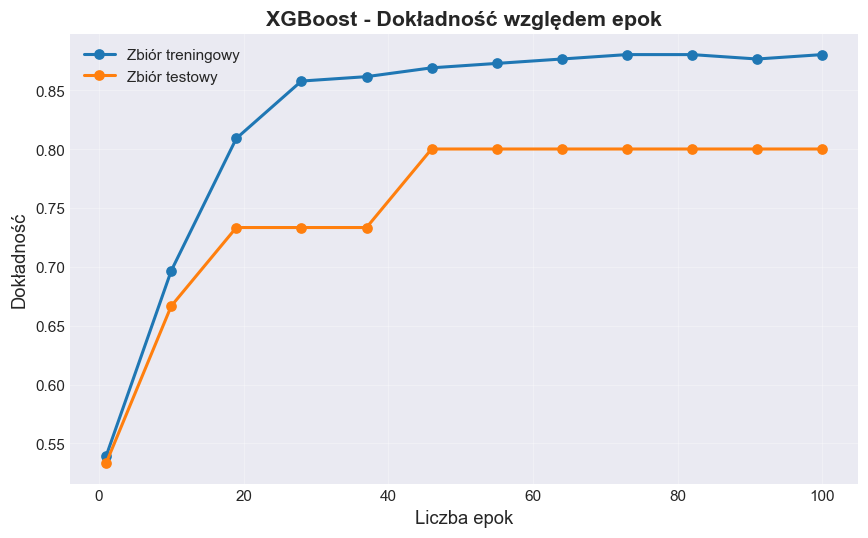

✓ Zapisano: heart_xgb_output/xgb_epoki_dokładność.png


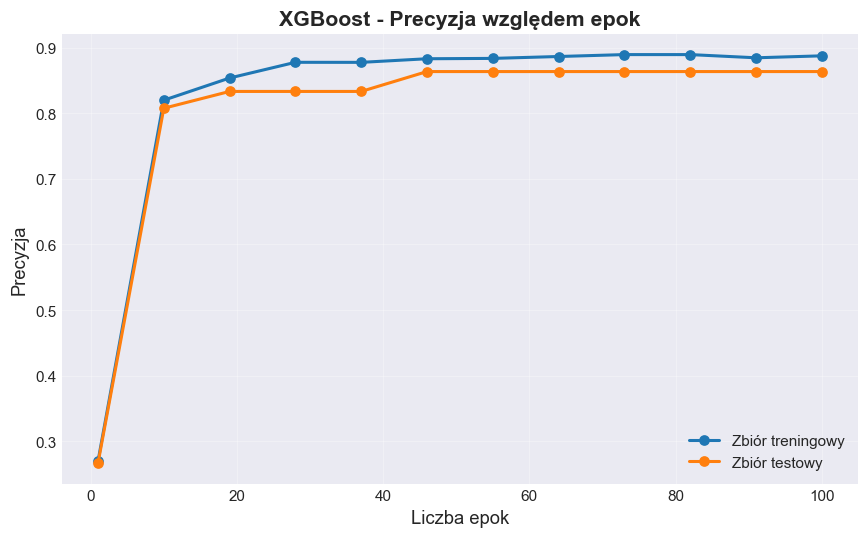

✓ Zapisano: heart_xgb_output/xgb_epoki_precyzja.png


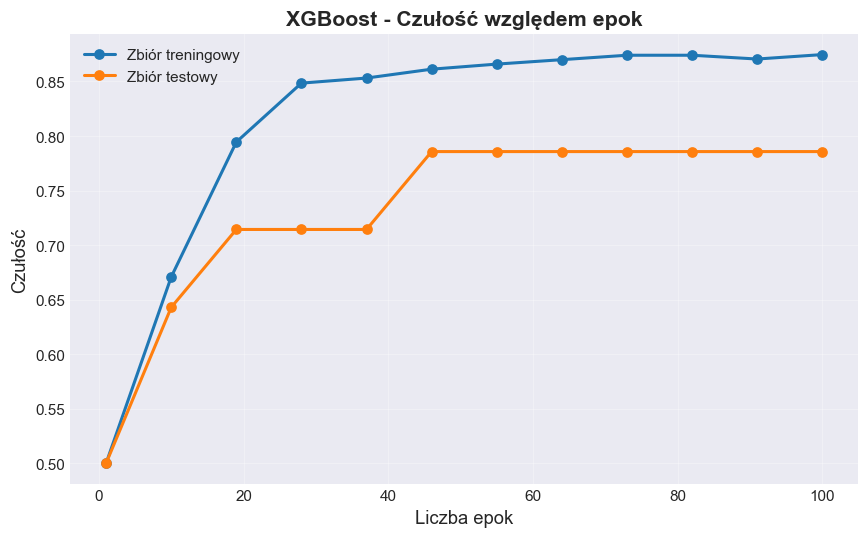

✓ Zapisano: heart_xgb_output/xgb_epoki_czułość.png


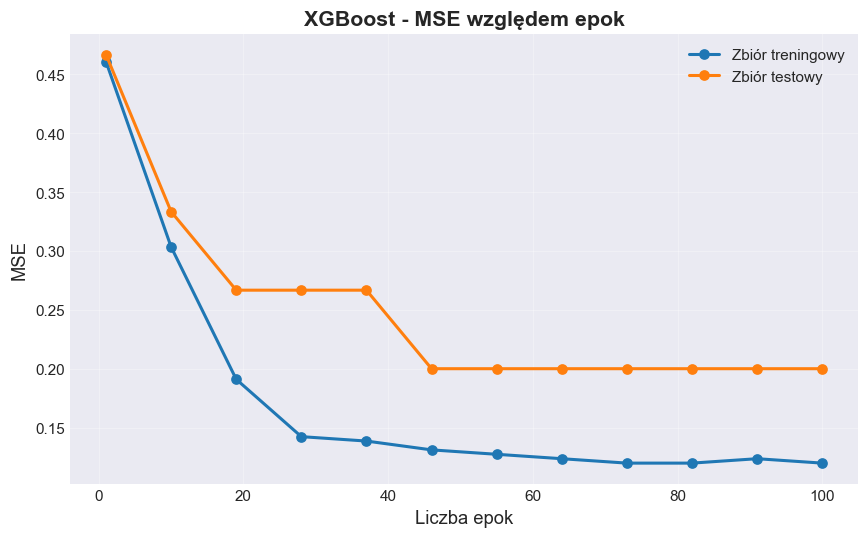

✓ Zapisano: heart_xgb_output/xgb_epoki_mse.png


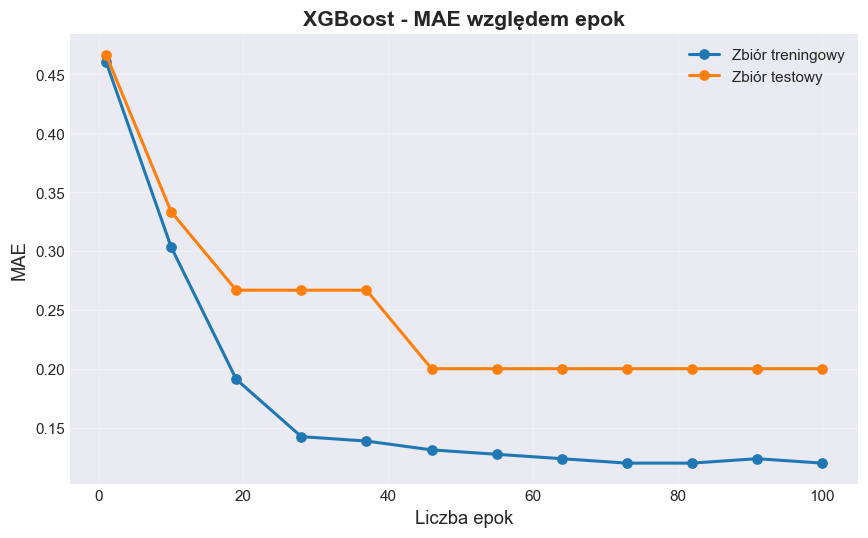

✓ Zapisano: heart_xgb_output/xgb_epoki_mae.png


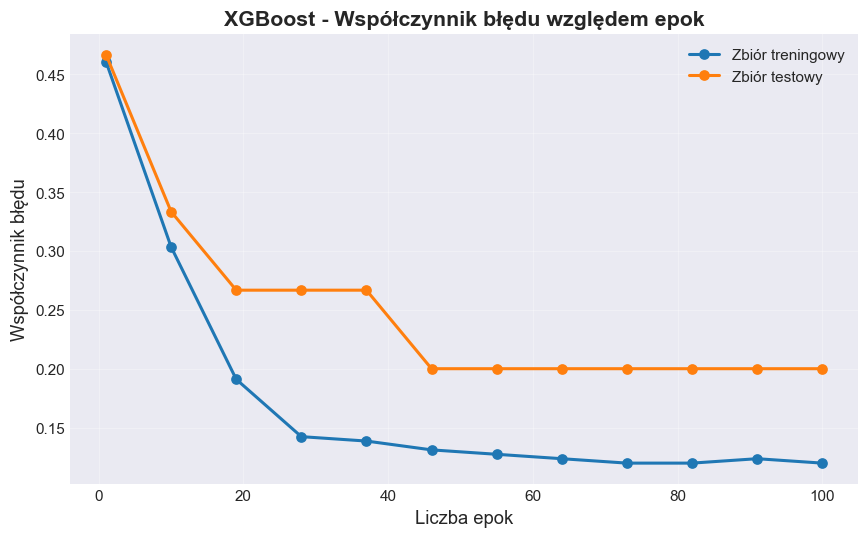

✓ Zapisano: heart_xgb_output/xgb_epoki_blad.png


In [6]:
from xgboost import XGBClassifier
metrics_calc_epoch = MetricsCalculator(average='macro')
base_params = xgb_model.get_params()
max_epochs = int(base_params.get('n_estimators', 100))
epoch_values = np.linspace(1, max_epochs, num=min(max_epochs, 12), dtype=int)
epoch_values = np.unique(epoch_values)
epoch_records = []
for epoch in epoch_values:
    params = base_params.copy()
    params['n_estimators'] = int(epoch)
    estimator = XGBClassifier(**params)
    estimator.fit(X_train_norm, y_train_enc, verbose=False)
    for subset_name, X_subset, y_subset in [('Trening', X_train_norm, y_train_enc), ('Test', X_test_norm, y_test_enc)]:
        preds = estimator.predict(X_subset)
        probas = estimator.predict_proba(X_subset)
        classification = metrics_calc_epoch.calculate_classification_metrics(y_subset, preds)
        errors = metrics_calc_epoch.calculate_error_metrics(y_subset, preds)
        roc_auc_val = metrics_calc_epoch.calculate_roc_auc(y_subset, probas)
        if roc_auc_val is None:
            roc_auc_val = np.nan
        epoch_records.append({
            'Epoka': int(epoch),
            'Zestaw': subset_name,
            'Dokładność': classification['accuracy'],
            'Precyzja': classification['precision'],
            'Czułość': classification['recall'],
            'ROC_AUC': roc_auc_val,
            'MSE': errors['mse'],
            'MAE': errors['mae']
        })
epoch_metrics_df = pd.DataFrame(epoch_records)
epoch_metrics_df['Współczynnik błędu'] = 1.0 - epoch_metrics_df['Dokładność']
epoch_metrics_df.to_csv(f"{output_dir}/xgb_epoki_metryki.csv", index=False)
print(f"✓ Zapisano: {output_dir}/xgb_epoki_metryki.csv")
label_map = {'Trening': 'Zbiór treningowy', 'Test': 'Zbiór testowy'}
metrics_to_plot = [
    ('Dokładność', 'XGBoost - Dokładność względem epok'),
    ('Precyzja', 'XGBoost - Precyzja względem epok'),
    ('Czułość', 'XGBoost - Czułość względem epok'),
    ('MSE', 'XGBoost - MSE względem epok'),
    ('MAE', 'XGBoost - MAE względem epok')
]
for metric_name, plot_title in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for dataset_name in ['Trening', 'Test']:
        subset = epoch_metrics_df.loc[epoch_metrics_df['Zestaw'] == dataset_name]
        plt.plot(subset['Epoka'], subset[metric_name], marker='o', linewidth=2, label=label_map[dataset_name])
    plt.title(plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Liczba epok', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/xgb_epoki_{metric_name.lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Zapisano: {output_dir}/xgb_epoki_{metric_name.lower()}.png")
plt.figure(figsize=(8, 5))
for dataset_name in ['Trening', 'Test']:
    subset = epoch_metrics_df.loc[epoch_metrics_df['Zestaw'] == dataset_name]
    plt.plot(subset['Epoka'], subset['Współczynnik błędu'], marker='o', linewidth=2, label=label_map[dataset_name])
plt.title('XGBoost - Współczynnik błędu względem epok', fontsize=14, fontweight='bold')
plt.xlabel('Liczba epok', fontsize=12)
plt.ylabel('Współczynnik błędu', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_epoki_blad.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/xgb_epoki_blad.png")

## 4. Trening Finalnego Modelu


Model wytrenowany pomyślnie!
Czas treningu: 0.978 sekund


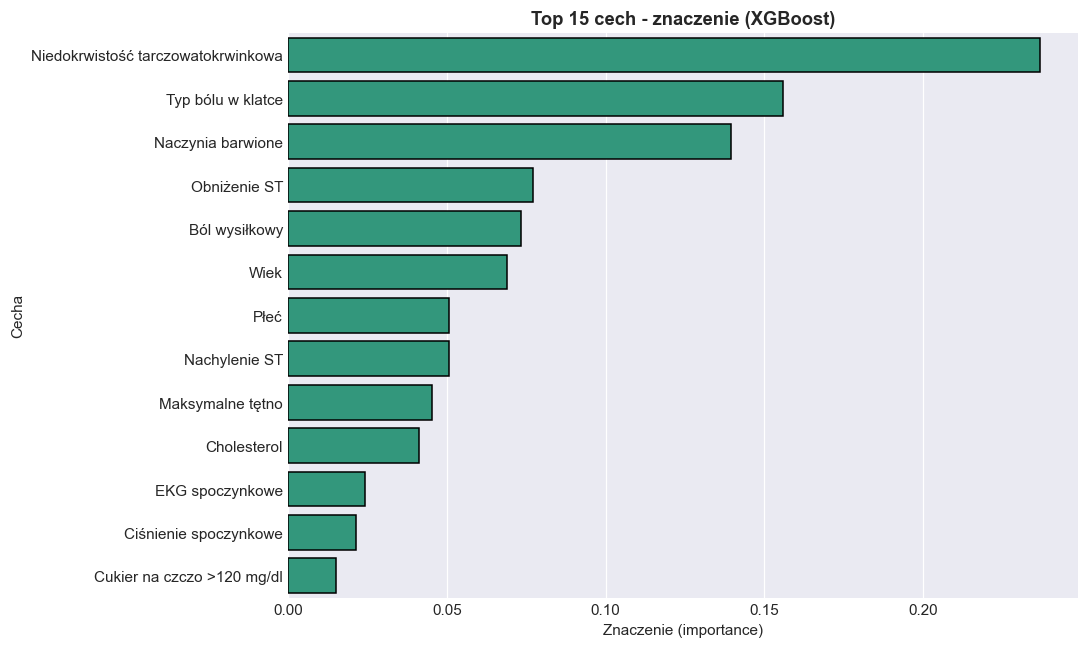

✓ Zapisano: heart_xgb_output/feature_importances.csv oraz feature_importances_top15.png


In [7]:
xgb_model.fit(X_train_norm, y_train_enc)
training_time = xgb_model.get_training_time()

print(f"Model wytrenowany pomyślnie!")
print(f"Czas treningu: {training_time:.3f} sekund")

if hasattr(xgb_model.model, 'feature_importances_'):
    importances = xgb_model.model.feature_importances_
    feat_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances,
        'feature_pl': [pl(c) for c in X_train.columns]
    }).sort_values('importance', ascending=False)
    feat_df.to_csv(f"{output_dir}/feature_importances.csv", index=False)
    plt.figure(figsize=(10,6))
    sns.barplot(
        x='importance',
        y='feature_pl',
        data=feat_df.head(15),
        color=plt.colormaps.get('viridis')(0.6),
        edgecolor='black'
    )
    plt.title('Top 15 cech - znaczenie (XGBoost)', fontweight='bold')
    plt.xlabel('Znaczenie (importance)')
    plt.ylabel('Cecha')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_importances_top15.png", dpi=300)
    plt.show()
    print(f"✓ Zapisano: {output_dir}/feature_importances.csv oraz feature_importances_top15.png")
else:
    print("⚠ Brak atrybutu feature_importances_ w modelu")

## 5. Ewaluacja na Zbiorze Testowym


In [8]:
y_pred = xgb_model.predict(X_test_norm)
y_pred_proba = xgb_model.predict_proba(X_test_norm)

metrics_calc = MetricsCalculator(average='macro')
metrics = metrics_calc.calculate_all_metrics(y_test_enc, y_pred, y_pred_proba)

print("Metryki na zbiorze testowym:")
print("="*50)
for metric_key, value in metrics.items():
    if metric_key == 'confusion_matrix':
        continue
    metric_label = metric_name_map.get(metric_key, metric_key)
    if value is None:
        print(f"{metric_label:25s}: brak danych")
    elif isinstance(value, (int, float, np.floating)):
        print(f"{metric_label:25s}: {float(value):.4f}")
    else:
        print(f"{metric_label:25s}: {value}")

Metryki na zbiorze testowym:
Dokładność               : 0.8000
Precyzja                 : 0.8636
Czułość                  : 0.7857
MSE                      : 0.2000
MAE                      : 0.2000
RMSE                     : 0.4472
ROC-AUC                  : 0.9643


## 6. Wizualizacje


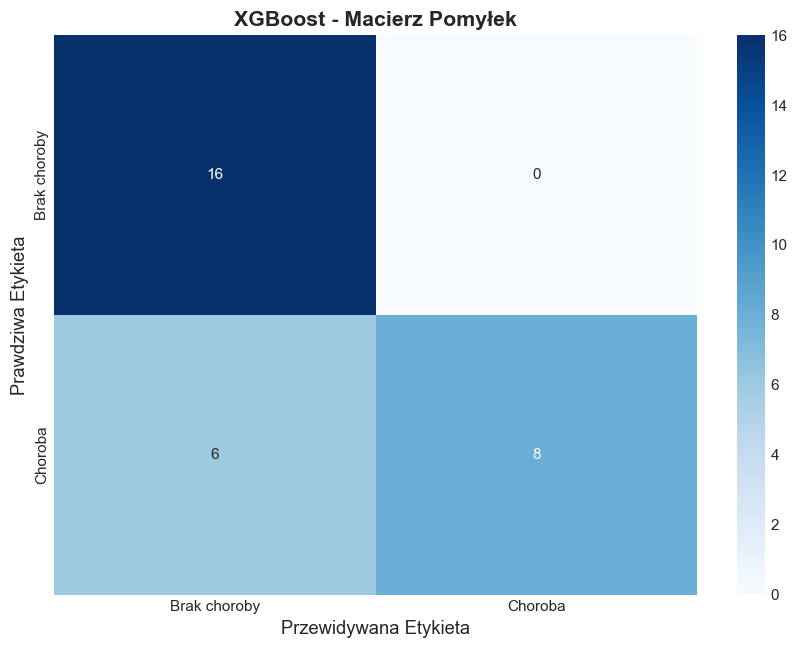

✓ Zapisano: heart_xgb_output/confusion_matrix.png

Raport klasyfikacji:
              precision    recall  f1-score   support

Brak choroby       0.73      1.00      0.84        16
     Choroba       1.00      0.57      0.73        14

    accuracy                           0.80        30
   macro avg       0.86      0.79      0.78        30
weighted avg       0.85      0.80      0.79        30

✓ Zapisano: heart_xgb_output/classification_report.txt

Liczba błędnie sklasyfikowanych próbek: 6 (20.00%)

Przykładowe predykcje (pierwsze 15):
   Klasa rzeczywista Klasa przewidywana  Prawdopodobieństwo choroby
0       Brak choroby       Brak choroby                    0.270175
1       Brak choroby       Brak choroby                    0.279437
2       Brak choroby       Brak choroby                    0.421918
3            Choroba       Brak choroby                    0.496151
4       Brak choroby       Brak choroby                    0.218577
5       Brak choroby       Brak choroby         

In [9]:
cm_plotter = ConfusionMatrixPlotter(figsize=(8, 6))
fig = cm_plotter.plot(
    metrics['confusion_matrix'],
    class_names=class_display_names,
    title='XGBoost - Macierz Pomyłek'
)
fig.savefig(f"{output_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/confusion_matrix.png")

from sklearn.metrics import classification_report
report = classification_report(y_test_enc, y_pred, target_names=class_display_names)
with open(f"{output_dir}/classification_report.txt", 'w') as f:
    f.write(report)
print("\nRaport klasyfikacji:")
print(report)
print(f"✓ Zapisano: {output_dir}/classification_report.txt")

mis_idx = np.where(y_test_enc != y_pred)[0]
print(f"\nLiczba błędnie sklasyfikowanych próbek: {len(mis_idx)} ({len(mis_idx)/len(y_test_enc)*100:.2f}%)")

def decode_label(idx):
    idx = int(idx)
    if 0 <= idx < len(class_display_names):
        return class_display_names[idx]
    return str(idx)

sample_df = pd.DataFrame({
    'Klasa rzeczywista': [decode_label(idx) for idx in y_test_enc[:15]],
    'Klasa przewidywana': [decode_label(idx) for idx in y_pred[:15]],
    'Prawdopodobieństwo choroby': y_pred_proba[:15, 1]
})
sample_df.to_csv(f"{output_dir}/sample_predictions_head15.csv", index=False)
print(f"\nPrzykładowe predykcje (pierwsze 15):")
print(sample_df)
print(f"✓ Zapisano: {output_dir}/sample_predictions_head15.csv")

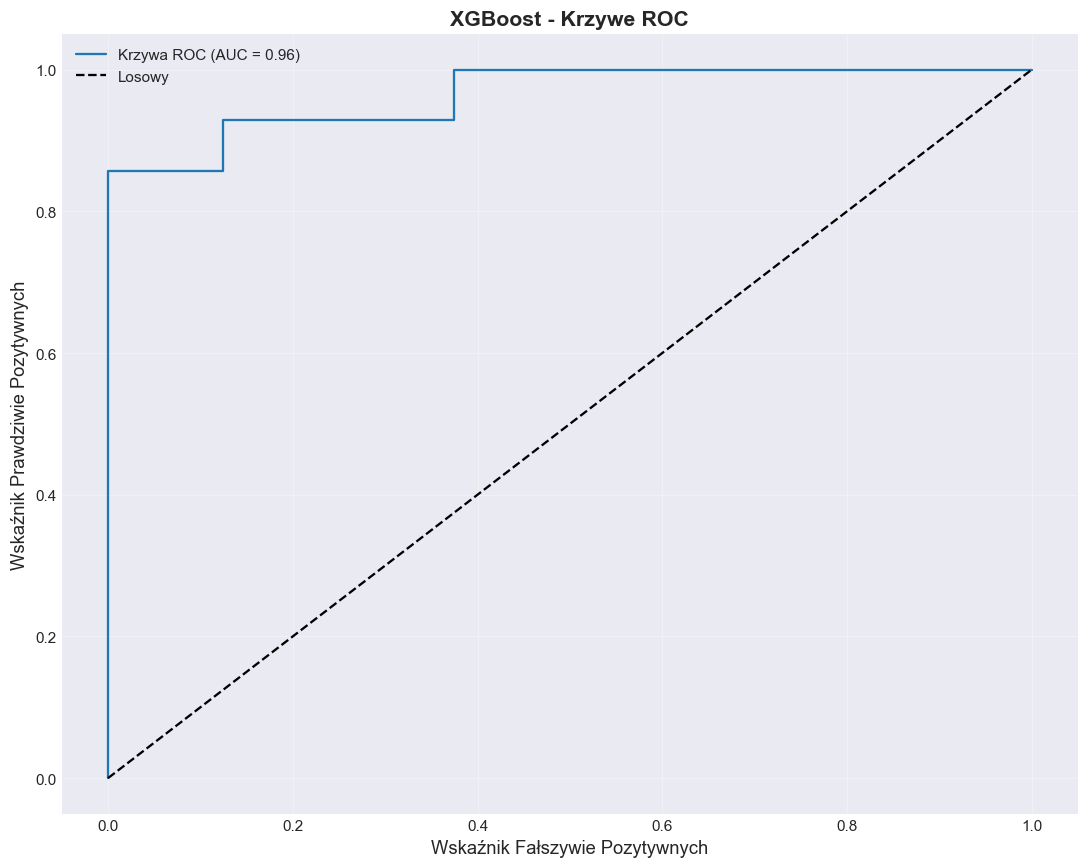

✓ Zapisano: heart_xgb_output/roc_curves.png


In [10]:
roc_plotter = ROCCurvePlotter(figsize=(10, 8))
n_classes = preprocessor.get_num_classes()
fig = roc_plotter.plot(y_test_enc, y_pred_proba, n_classes,
                      title='XGBoost - Krzywe ROC',
                      class_names=class_display_names)
fig.savefig(f"{output_dir}/roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/roc_curves.png")

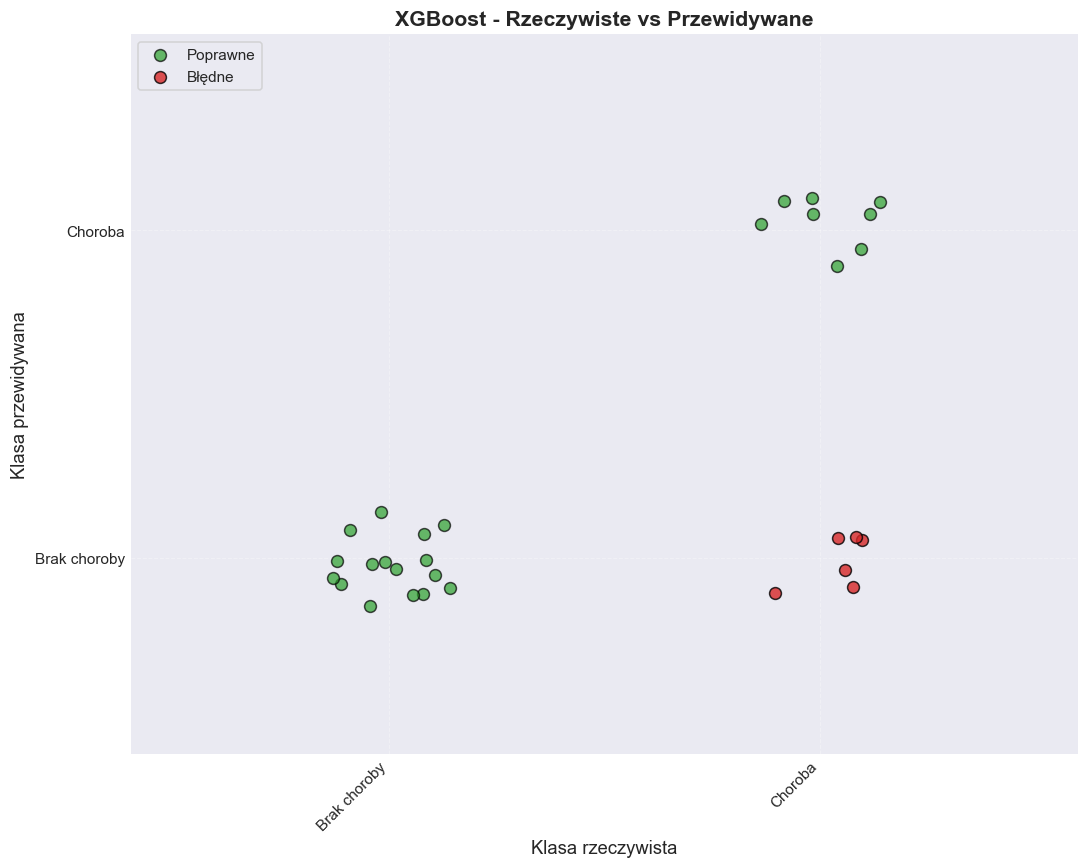

✓ Zapisano: heart_xgb_output/prediction_scatter.png


In [11]:
scatter_plotter = PredictionScatterPlotter(figsize=(10, 8))
fig = scatter_plotter.plot(
    y_test_enc,
    y_pred,
    title='XGBoost - Rzeczywiste vs Przewidywane',
    class_labels=encoded_class_labels
)
fig.savefig(f"{output_dir}/prediction_scatter.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Zapisano: {output_dir}/prediction_scatter.png")

## 7. Podsumowanie


In [12]:
print("="*60)
print("PODSUMOWANIE - XGBOOST")
print("="*60)
print(f"\nParametry modelu: {tuner.best_params_}")
print(f"\nWyniki CV (5-fold):")
for metric, score in cv_scores.items():
    if 'mean' in metric:
        print(f"  {metric}: {score:.4f}")
print(f"\nWyniki testowe:")
print(f"  Dokładność: {metrics['accuracy']:.4f}")
print(f"  Precyzja: {metrics['precision']:.4f}")
print(f"  Czułość: {metrics['recall']:.4f}")
print(f"  ROC-AUC: {metrics.get('roc_auc', 'N/A')}")
print(f"\nCzas treningu: {training_time:.3f}s")
print("="*60)

PODSUMOWANIE - XGBOOST

Parametry modelu: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Wyniki CV (5-fold):
  accuracy_mean: 0.8314
  precision_macro_mean: 0.8435
  recall_macro_mean: 0.8247
  roc_auc_ovr_mean: 0.8247
  mse_mean: 0.1686
  mae_mean: 0.1686

Wyniki testowe:
  Dokładność: 0.8000
  Precyzja: 0.8636
  Czułość: 0.7857
  ROC-AUC: 0.9642857142857143

Czas treningu: 0.978s
